## Lets look at the issues brought up in our meeting

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind', n_colors=5576)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
matplotlib.rcParams['font.family'] = 'serif'
import os
import glob
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

Targets in our dataframe: 500


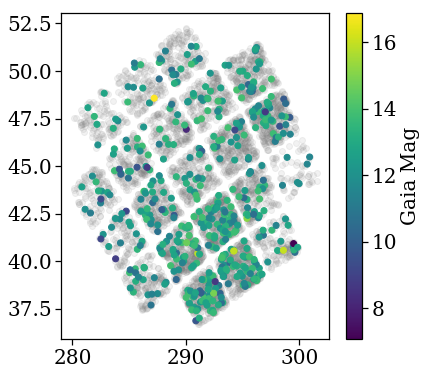

In [2]:
from sklearn.utils import shuffle
kdf = pd.read_csv(__datdir__+'rcxyu18.csv')
nstars = 500
df = shuffle(kdf, random_state=24601).reset_index(drop=True)[:nstars]

print('Targets in our dataframe: '+str(len(df)))
f,a = plt.subplots(figsize=(6,6))
a.scatter(kdf.ra, kdf.dec, c = 'grey', alpha=.1)
c = a.scatter(df.ra, df.dec, c=df.GAIAmag, cmap='viridis')
f.colorbar(c, label=r"Gaia Mag")
plt.show()

## Plot a distribution of average separation for 500 stars

In [3]:
thetaij = np.sqrt(np.subtract.outer(df.ra.values, df.ra.values)**2 + np.subtract.outer(df.dec.values, df.dec.values)**2)

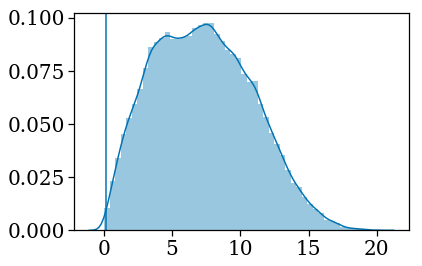

With 500 stars in our dataframe--
Number of separations below 0.125deg : 0


In [4]:
seps = np.tril(thetaij).flatten()
seps = seps[seps > 0.]
sns.distplot(seps)
plt.axvline(0.125)
plt.show()
print('With '+str(nstars)+' stars in our dataframe--')
print('Number of separations below 0.125deg : '+str(len(seps[seps<0.0125])))

## Does the Lindegren equation work as it should?
We can test this by checking whether the equation 
\begin{equation}
\frac{\rm{cov}_{ij}}{\sigma_i,\sigma_j}
\end{equation}
is between $0$ and $1$

In [5]:
def kernel(ra, dec, sigma, p):
    '''
    p[0] : Offset
    p[1] : Exponential decay scale
    '''
    thetaij = np.sqrt(np.subtract.outer(ra, ra)**2 + np.subtract.outer(dec, dec)**2)
    cov = p[0] * np.exp(-thetaij / p[1])
    np.fill_diagonal(cov, np.diag(cov) + sigma**2)
    return cov

In [6]:
p = [285.0*10**-6, 14.]
cov = kernel(kdf.ra.values, kdf.dec.values, kdf.parallax_error.values, p)

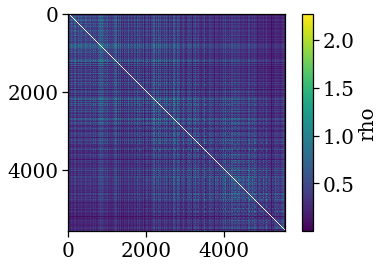

In [7]:
rho = cov / np.outer(kdf.parallax_error.values, kdf.parallax_error.values)
np.fill_diagonal(rho, np.nan)
c = plt.imshow(rho)
plt.colorbar(c, label='rho')
plt.show()

With 31024900 total correlations--
Number of rho values > 1. : 316146


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


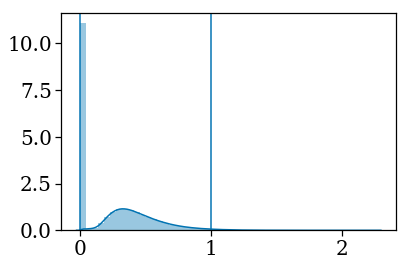

In [8]:
rhos = np.tril(rho).flatten()
sns.distplot(rhos[~np.isnan(rhos)])
plt.axvline(1.)
plt.axvline(0.)
print('With '+str(len(rhos))+' total correlations--')
print('Number of rho values > 1. : '+str(len(rhos[rhos>1.])))

This is curious, and absolutely should not be happening. Is there an issue with my Kernel?

Maybe its due to the inferior fit to the covariance by Lindegren et al. Lets check

In [9]:
thetaij = np.sqrt(np.subtract.outer(kdf.ra.values, kdf.ra.values)**2 + np.subtract.outer(kdf.dec.values, kdf.dec.values)**2)
rhos = np.tril(rho).flatten()
covs = np.tril(cov).flatten()
seps = np.tril(thetaij).flatten()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


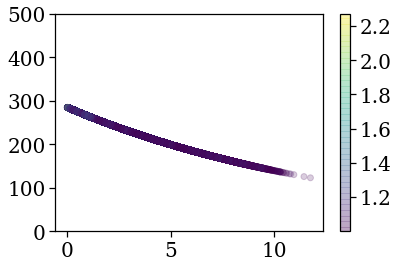

In [38]:
sel = np.where(seps > 0.)
hirhos = np.where(rhos > 1.)
x = np.linspace(0., 20., 1000.)
y = p[0] * np.exp(-x / p[1]) * 1e6
plt.scatter(seps[hirhos], covs[hirhos]*1e6, alpha=.2, c=rhos[hirhos])
# plt.plot(x, y, linestyle='-.',linewidth=2., c='k')
plt.ylim(0., 500.)
plt.colorbar()
plt.show()